# Dropping a ball
Written by Tim Atherton for Computational Physics
    - Modified by: Kai Stewart, Felix Hu
January 16, 2020

This program aims to simulate the motion of a ball dropped from an initial height of $y0$ under gravity $g$ using the Euler discretization.

## Import libraries for plotting and numerical work

In [2]:
import sys
print(sys.version)

3.6.10 |Anaconda, Inc.| (default, Jan  7 2020, 15:01:53) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Set up general parameters for the calculation
- Gravitational acceleration constant: $10 \frac{m}{s^2}$

- Initial height: $y_0$ in $m$
- Initial velocity: $v_0$ in $\frac{m}{s}$
- Initial time: $t_0$ in $s$
- Time resolution: $dt$ in $0.1s$
- Total simulation time: $t_f$ in $s$

In [78]:
g = 10 ; y0 = 1.0 ; v0 = 0 ; t0 = 0 ; dt = 0.05 ; tf = 1.9 

## Set number of steps to take in the trajectory calculation

In [79]:
nsteps = int(tf/dt)+1
print(nsteps)

38


## Set the properties of the ball under investigations
- The properties $S_b$ of the individual balls is a collection of elements pertaining to the various physical properties of the ball in the test set.
- Property list:
    - Ball mass: $m$ in grams
    - Ball diameter: $d$ in mm
    - Ball radius: $r$ in mm
    - Ball surface area: $s_a = 4\pi r^2$ in mm$^2$ 
    - Ball material: $b_{mat}:$ $\{$'plastic':0, 'rubber':1, 'foam':2$\}$
    - Porosity: $p:$ $\{ 0.0, ..., 1.0 \}$
- Red Foam Ball
    - $S_r:$ $\{$ $m:$ 0.40,  $d:$ (29, 33), $r:$ (14.5, 16.5), $s_a:$ 3019.07, $b_{mat}:$, $p:$, $\}$
    - Note: The surface area of the red ball is computed using $r = \frac{1}{2}r_1r_2$
- Black Rubber Ball
    - $S_b:$ $\{$ $m:$ 24.55, $d:$ 39.8, $r:$ 19.9, $s_a:$ 4976.4, $b_{mat}:$, $p:$, $\}$
- White Plastic Ball
    - $S_w:$ $\{$ $m:$ 2.80, $d:$ 40.2, $r:$ 20.1, $s_a:$ 5076.94, $b_{mat}:$, $p:$, $\}$

In [80]:
Sr = {'color': 'Red',   'm': 0.40,  'd': 0.0, 'r': 15.5, 's_a': 3019.07, 'b_mat': None, 'p': 0.0, 'drag': 0.50}
Sb = {'color': 'Black', 'm': 24.55, 'd': 0.0, 'r': 19.9, 's_a': 4976.40, 'b_mat': None, 'p': 0.0, 'drag': 0.47}
Sw = {'color': 'White', 'm': 2.80,  'd': 0.0, 'r': 20.1, 's_a': 5076.94, 'b_mat': None, 'p': 0.0, 'drag': 0.47}

### Load Tracker output data for the three balls

##### Red Ball

In [128]:
red_ball = pd.read_csv('red_ball.txt', delimiter="\t")

In [129]:
red_t = red_ball['t']; red_x = red_ball['x']; red_y = red_ball['y']

##### Black Ball

In [83]:
black_ball = pd.read_csv('black_ball.txt', delimiter="\t")

In [84]:
black_t = black_ball['t']; black_x = black_ball['x']; black_y = black_ball['y']

##### White Ball

In [85]:
white_ball = pd.read_csv('white_ball.txt', delimiter="\t")

In [86]:
white_t = white_ball['t']; white_x = white_ball['x']; white_y = white_ball['y']

#### Function Contract: coefficient of drag, surface area of object, velocity of object, mass of object
- [Documentation](https://www.nuclear-power.net/nuclear-engineering/fluid-dynamics/what-is-drag-air-and-fluid-resistance/drag-force-drag-equation/)
- Units: m = grams, area = mm$^2$, velocity = m/s, coefficient = unitless
- Calculates the drag acceleration of an object with the given properties

In [87]:
def drag_accel(coefficient, area, flow_v, m):
    return (coefficient * (area * 0.000001) * ((1.225 * (flow_v**2))/2)) / (m * 0.001)

## Main loop, where we successively update velocity and time according to the Euler rule

In [110]:
t = np.linspace(t0,tf,nsteps); v = np.zeros([nsteps]); y = np.zeros([nsteps])

In [111]:
y[0] = white_y[0]; v[0] = v0

In [112]:
for i in range(1, nsteps):
    v[i] = v[i-1] + (dt * (-g + drag_accel(Sr['drag'], Sr['s_a'], v[i-1], Sr['m'])))
    y[i] = y[i-1] + v[i] * dt
    if y[i] < 0:
        break

In [113]:
v

array([ 0.        , -0.5       , -0.97110656, -1.36211495, -1.64768432,
       -1.83391729, -1.94521349, -2.00789903, -2.04194504, -2.06005562,
       -2.06958027, -2.07455902, -2.07715318, -2.07850258,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ])

In [114]:
y

array([ 1.03717573,  1.01217573,  0.9636204 ,  0.89551465,  0.81313044,
        0.72143457,  0.6241739 ,  0.52377895,  0.4216817 ,  0.31867891,
        0.2151999 ,  0.11147195,  0.00761429, -0.09631084,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ])

In [115]:
y = y[y != 0.]
y = y[y > 0.]
y

array([1.03717573, 1.01217573, 0.9636204 , 0.89551465, 0.81313044,
       0.72143457, 0.6241739 , 0.52377895, 0.4216817 , 0.31867891,
       0.2151999 , 0.11147195, 0.00761429])

In [116]:
t = t[0:len(y)]

In [130]:
red_y = red_y.values[0: len(red_y.values) - 2]

In [131]:
red_y

array([1.0250979 , 1.02465797, 1.02104535, 1.0022542 , 0.98043427,
       0.94131901, 0.90099481, 0.84867565, 0.78648862, 0.71782725,
       0.64244002, 0.56176491, 0.4753989 , 0.39465721, 0.28364497,
       0.20984632, 0.10398314])

In [132]:
red_t = red_t.values[0:len(red_y)]

In [133]:
red_t

array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
       0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
       0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
       0.5       , 0.53333333])

## Compare the simulation to tracker plots

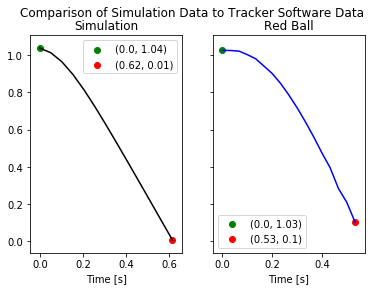

In [134]:
%matplotlib inline
fig, axes = plt.subplots(1,2, sharey=True)
plt.suptitle('Comparison of Simulation Data to Tracker Software Data')

axes[0].plot(t[0:len(y)],y, color='k')
axes[0].set_title("Simulation")
axes[0].set_xlabel('Time [s]')
axes[0].scatter(0.0, y[0], label='({}, {})'.format(round(t[0], 2), round(y[0], 2) ), color='g')
axes[0].scatter(t[-1], y[-1], label='({}, {})'.format(round(t[-1], 2), round(y[-1], 2)), color='r')

# axes[1].plot(red_t.values[3:], red_y.values[3:])
# axes[1].set_title('{} Ball'.format(Sr['color']))
# axes[1].set_xlabel('Time [s]')

# axes[1].plot(black_t.values, black_y.values)
# axes[1].set_title('{} Ball'.format(Sb['color']))
# axes[1].set_xlabel('Time [s]')

axes[1].plot(red_t, red_y, color='b')
axes[1].set_title('{} Ball'.format(Sr['color']))
axes[1].set_xlabel('Time [s]')

label = '({}, {})'.format(round(red_t[0], 2), round(red_y[0], 2) )
axes[1].scatter(red_t[0], red_y[0], label=label, color='g')

label = '({}, {})'.format(round(red_t[-1], 2), round(red_y[-1], 2))
axes[1].scatter(red_t[-1], red_y[-1], label=label, color='r')

# Legends
axes[0].legend()
axes[1].legend()

plt.savefig('ball_drop_{}.png'.format(Sr['color']), dpi=300)

In [ ]:
%matplotlib inline
fig, axes = plt.subplots(1,4, sharey=True)
plt.suptitle('Comparison of Simulation Data to Tracker Software Data')

axes[0].plot(t[0:7],y[0:7])
axes[0].set_title("Simulation")
axes[0].set_xlabel('Time [s]')

axes[1].plot(red_t, red_y)
axes[1].set_title('{} Ball'.format(Sr['color']))
axes[1].set_xlabel('Time [s]')

axes[2].plot(black_t, black_y)
axes[2].set_title('{} Ball'.format(Sb['color']))
axes[2].set_xlabel('Time [s]')

axes[3].plot(white_t[0:len(white_y)], white_y)
axes[3].set_title('{} Ball'.format(Sw['color']))
axes[3].set_xlabel('Time [s]')

plt.savefig('ball_drop.png', dpi=300)

In [ ]:
%matplotlib inline
plt.plot(t,v)
plt.title('Velocity of the {} ball without drag'.format(S['color']))
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')